In [1]:
import h5py
import numpy as np
import os
import random
from os.path import join
from keras import layers
from keras.models import Sequential
from keras.layers import Conv2D, Dense, MaxPooling2D, Dropout, Flatten, Activation
from keras.utils import to_categorical

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
dataset = 'UCF11'
nb_classes = int(dataset[3:])

In [3]:
def train_generator(dataset_dir, batch_size):
    
    all_files = os.listdir(dataset_dir)
    
    while True:
        images = []
        labels = []

        for _ in range(batch_size):
            
            random_filename = random.choice(all_files)
            
            with h5py.File(join(dataset_dir, random_filename), 'r') as hf:
                frames = hf['X'][:]
                fr_labels = hf['Y'][:]
                random_idx = np.random.randint(frames.shape[0])
                
                images.append(frames[random_idx])
                labels.append(fr_labels)
                
        images = np.array(images)
        labels = to_categorical(np.array(labels), nb_classes)
        
        yield images, labels
        
        

def valid_generator(dataset_dir, batch_size):
    
    all_files = os.listdir(dataset_dir)
    
    while True:
        
        for filename in all_files:

            with h5py.File(join(dataset_dir, filename), 'r') as hf:
                frames = hf['X'][:]
                single_label = hf['Y'][:][0]

                fr_labels = np.array([single_label] * frames.shape[0])

                yield frames, to_categorical(fr_labels, nb_classes)

In [4]:
separate_dataset_dir = join('datasets', dataset, 'separate_frames_50_h_120_w_160')
train_dir = join(separate_dataset_dir, 'train')
valid_dir = join(separate_dataset_dir, 'valid')

train_samples_count = len(os.listdir(train_dir))
valid_samples_count = len(os.listdir(valid_dir))

with h5py.File(join(train_dir, os.listdir(train_dir)[0])) as hf:
    image_shape = hf['X'][:].shape[1:]
    print('Image input shape is', image_shape)

Image input shape is (120, 160, 3)


In [14]:
def build_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), padding='same',
                     input_shape=image_shape))
    model.add(Activation('relu'))
    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(nb_classes))
    model.add(Activation('softmax'))
    
    return model

In [6]:
batch_size = 128

from keras import metrics
from functools import partial

top_3_k_categorical_accuracy = partial(metrics.top_k_categorical_accuracy, k=3)
top_3_k_categorical_accuracy.__name__ = 'top_3'

model = build_model()
print(model.summary())
model.compile(optimizer='sgd', loss='categorical_crossentropy', 
              metrics=['accuracy', top_3_k_categorical_accuracy])

In [7]:
history = model.fit_generator(train_generator(train_dir, batch_size),
                    steps_per_epoch=train_samples_count * 50 // batch_size, 
                    validation_data=valid_generator(valid_dir, batch_size),
                    validation_steps=valid_samples_count,
                    epochs=20)

Epoch 1/20
369/369 [==============================] - 92s 249ms/step - loss: 2.4135 - acc: 0.1377 - top_3: 0.3449 - val_loss: 2.3810 - val_acc: 0.1335 - val_top_3: 0.2811
Epoch 2/20
369/369 [==============================] - 87s 236ms/step - loss: 2.1232 - acc: 0.2551 - top_3: 0.5072 - val_loss: 2.1973 - val_acc: 0.1843 - val_top_3: 0.5102
Epoch 3/20
369/369 [==============================] - 85s 231ms/step - loss: 1.7007 - acc: 0.4221 - top_3: 0.6860 - val_loss: 2.3400 - val_acc: 0.2358 - val_top_3: 0.5146
Epoch 4/20
369/369 [==============================] - 87s 237ms/step - loss: 1.2698 - acc: 0.5751 - top_3: 0.8100 - val_loss: 2.4149 - val_acc: 0.3208 - val_top_3: 0.5740
Epoch 5/20
369/369 [==============================] - 87s 236ms/step - loss: 0.9354 - acc: 0.6905 - top_3: 0.8862 - val_loss: 2.4566 - val_acc: 0.3520 - val_top_3: 0.6095
Epoch 6/20
369/369 [==============================] - 87s 234ms/step - loss: 0.7090 - acc: 0.7662 - top_3: 0.9278 - val_loss: 2.6357 - val_acc: 0

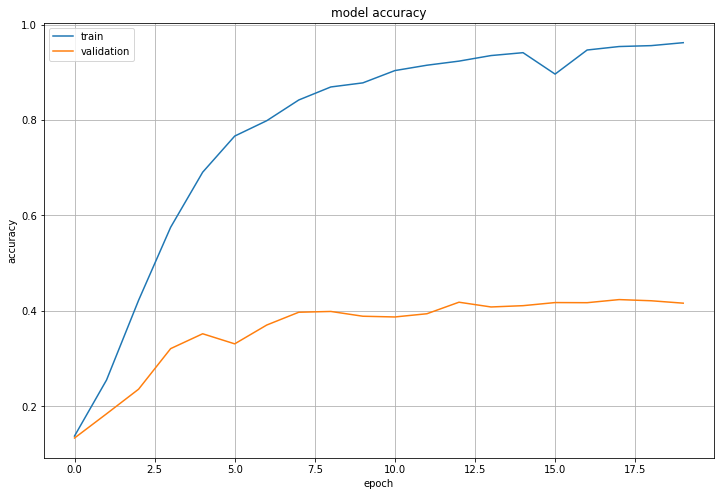

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(12, 8))
plt.grid()
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy (training with SGD)')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [15]:
batch_size = 128

from keras import metrics
from functools import partial

top_3_k_categorical_accuracy = partial(metrics.top_k_categorical_accuracy, k=3)
top_3_k_categorical_accuracy.__name__ = 'top_3'

model = build_model()
print(model.summary())
model.compile(optimizer='adam', loss='categorical_crossentropy', 
              metrics=['accuracy', top_3_k_categorical_accuracy])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 120, 160, 32)      896       
_________________________________________________________________
activation_11 (Activation)   (None, 120, 160, 32)      0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 118, 158, 32)      9248      
_________________________________________________________________
activation_12 (Activation)   (None, 118, 158, 32)      0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 59, 79, 32)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 59, 79, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 59, 79, 64)        18496     
__________

In [16]:
history = model.fit_generator(train_generator(train_dir, batch_size),
                    steps_per_epoch=train_samples_count * 50 // batch_size, 
                    validation_data=valid_generator(valid_dir, batch_size),
                    validation_steps=valid_samples_count,
                    epochs=20)

Epoch 1/20
369/369 [==============================] - 92s 249ms/step - loss: 1.3316 - acc: 0.5809 - top_3: 0.7844 - val_loss: 2.1839 - val_acc: 0.4231 - val_top_3: 0.6583
Epoch 2/20
369/369 [==============================] - 88s 239ms/step - loss: 0.2775 - acc: 0.9105 - top_3: 0.9855 - val_loss: 2.6018 - val_acc: 0.4635 - val_top_3: 0.6758
Epoch 3/20
369/369 [==============================] - 88s 239ms/step - loss: 0.1525 - acc: 0.9517 - top_3: 0.9941 - val_loss: 3.0967 - val_acc: 0.4302 - val_top_3: 0.6652
Epoch 4/20
369/369 [==============================] - 87s 236ms/step - loss: 0.0984 - acc: 0.9691 - top_3: 0.9972 - val_loss: 3.4892 - val_acc: 0.4423 - val_top_3: 0.6442
Epoch 5/20
369/369 [==============================] - 85s 232ms/step - loss: 0.1064 - acc: 0.9676 - top_3: 0.9967 - val_loss: 3.4152 - val_acc: 0.4531 - val_top_3: 0.6649
Epoch 6/20
369/369 [==============================] - 88s 238ms/step - loss: 0.0664 - acc: 0.9794 - top_3: 0.9986 - val_loss: 3.6216 - val_acc: 0

KeyboardInterrupt: 